In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import math
import pandas as pd
from torch.autograd import Variable
import torch
import torch.nn as nn
import torchvision.transforms as transforms



torch.manual_seed(1)

In [2]:
fil='/Users/uzi720/Desktop/'
data=pd.read_csv(fil+"tsIE.csv",sep=';')

data['Sessions']=data['Sessions'].astype('float')
data['str']=data['Month of Year'].astype(str)
data['year']=data['str'].str[:4]
data['month']=data['str'].str[4:]
print(data.dtypes)
data.head()
data.tail()

Month of Year      int64
Sessions         float64
str               object
year              object
month             object
dtype: object


,Month of Year,Sessions,str,year,month
79,201508,154854.0,201508,2015,08
80,201509,100407.0,201509,2015,09
81,201510,96439.0,201510,2015,10
82,201511,79689.0,201511,2015,11
83,201512,99689.0,201512,2015,12


In [3]:
result = data.groupby(['year'], as_index=False).agg(
                      {'Sessions':['mean','std']})
print(result)
print(result.columns)
year=result['year']
print(type(year))
yrs=year.values.tolist()

mean=result['Sessions']['mean']
std=result['Sessions']['std']
yr_mu=mean.values.tolist()
yr_std=std.values.tolist()
print(type(yrs[0]),type(yr_mu[0]), type(yr_std[0]))
print(type(data.iloc[0,3]),data.iloc[0,3],type(data.iloc[0,1]),data.iloc[0,1]) 


   year       Sessions              
                  mean           std
0  2009   81125.666667  19857.182943
1  2010  101085.083333  34454.598082
2  2011  101923.750000  23524.255583
3  2012  102986.000000  26878.443242
4  2013  118917.083333  27364.116352
5  2014  113627.250000  35534.987438
6  2015  127608.166667  32894.264169
MultiIndex(levels=[[u'Sessions', u'year'], [u'mean', u'std', u'']],
           labels=[[1, 0, 0], [2, 0, 1]])
<class 'pandas.core.series.Series'>
(<type 'str'>, <type 'float'>, <type 'float'>)
(<type 'str'>, '2009', <type 'numpy.float64'>, 66953.0)


[52735.0, 69856.2, 77730.8, 87020.1, 94290.20000000001, 100113.0, 108201.00000000003, 124658.0, 136022.2, 151519.7] 151519.7


(184984.0, 52735.0, 10)

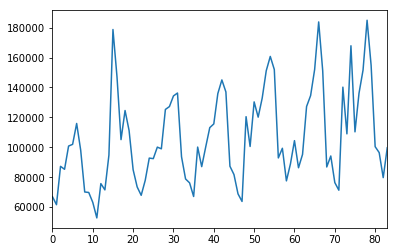

In [4]:
%matplotlib inline
data['Sessions'].plot()
cuts=[data['Sessions'].quantile(.1*i) for i in range(0,10)]
print cuts , data['Sessions'].quantile(.90)

max(data['Sessions']), min(data['Sessions']), len(cuts)


['2009' '2010' '2011' '2012' '2013' '2014' '2015']


year
2009    Axes(0.125,0.125;0.775x0.755)
2010    Axes(0.125,0.125;0.775x0.755)
2011    Axes(0.125,0.125;0.775x0.755)
2012    Axes(0.125,0.125;0.775x0.755)
2013    Axes(0.125,0.125;0.775x0.755)
2014    Axes(0.125,0.125;0.775x0.755)
2015    Axes(0.125,0.125;0.775x0.755)
Name: Sessions, dtype: object

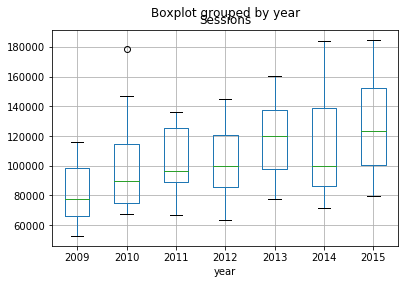

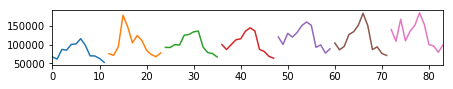

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline
#data.boxplot(column=['Sessions'],by="symbols")
data.boxplot(column="Sessions",by='year')
print(data['year'].unique())
#print(cuts)
fig, ax = plt.subplots(figsize=(7,1))
# use unstack()
data.groupby(['year'])['Sessions'].plot(ax=ax)
#plt.show()


In [ ]:
np.percentile(data.loc[(data.year=='2009')]['Sessions'].values,50)>=cuts[9]


In [ ]:
cuts[9]

In [ ]:
cut=data['Sessions'].quantile(.8)
cut

In [16]:
train_data=[]

labels=[]

yrs=data['year'].unique().tolist()
yrs=yrs[:-1]
for yr in yrs:
    
    temp=[data.loc[(data.year==yr)]['Sessions'].values.tolist()]
    label=0
    if np.percentile(data.loc[(data.year==yr)]['Sessions'].values,80)>=140000:
        label=0
        labels.append(label)
    elif np.percentile(data.loc[(data.year==yr)]['Sessions'].values,80)>=120000:
        label=1
        labels.append(label)
    elif np.percentile(data.loc[(data.year==yr)]['Sessions'].values,80)>=100000:
        label=2
        labels.append(label)
    else:
        pass
 

    prep=torch.FloatTensor(np.array(temp)).view(1,1,12)
    train_data.append((prep,label))

print(train_data, len(train_data))



([(
(0 ,.,.) = 

Columns 0 to 5 
   6.6953e+04  6.1591e+04  8.7241e+04  8.5263e+04  1.0081e+05  1.0196e+05

Columns 6 to 11 
   1.1592e+05  9.8061e+04  7.0083e+04  6.9759e+04  6.3127e+04  5.2735e+04
[torch.FloatTensor of size 1x1x12]
, 2), (
(0 ,.,.) = 

Columns 0 to 5 
   7.5694e+04  7.1488e+04  9.4771e+04  1.7878e+05  1.4720e+05  1.0512e+05

Columns 6 to 11 
   1.2459e+05  1.1118e+05  8.4997e+04  7.3469e+04  6.7868e+04  7.7872e+04
[torch.FloatTensor of size 1x1x12]
, 1), (
(0 ,.,.) = 

Columns 0 to 5 
   9.2757e+04  9.2395e+04  1.0010e+05  9.8969e+04  1.2531e+05  1.2723e+05

Columns 6 to 11 
   1.3434e+05  1.3630e+05  9.3639e+04  7.8804e+04  7.6179e+04  6.7068e+04
[torch.FloatTensor of size 1x1x12]
, 1), (
(0 ,.,.) = 

Columns 0 to 5 
   1.0013e+05  8.7042e+04  1.0027e+05  1.1314e+05  1.1562e+05  1.3593e+05

Columns 6 to 11 
   1.4506e+05  1.3700e+05  8.7305e+04  8.1748e+04  6.8835e+04  6.3757e+04
[torch.FloatTensor of size 1x1x12]
, 1), (
(0 ,.,.) = 

Columns 0 to 5 
   1.2047e+05  

In [15]:
test_data=[]

test_labels=[]


tmp=[data.loc[(data.year=='2015')]['Sessions'].values.tolist()]
test_labels=0
print(tmp)
if np.percentile(data.loc[(data.year=='2015')]['Sessions'].values,80)>=140000:
    test_labels=0

elif np.percentile(data.loc[(data.year=='2015')]['Sessions'].values,80)>=120000:
    test_labels=1

elif np.percentile(data.loc[(data.year=='2015')]['Sessions'].values,80)>=100000:
    test_labels=2

else:
    pass
print(test_labels)

prp=torch.FloatTensor(np.array(tmp)).view(1,1,12)
test_data.append((prp,test_labels))
print(test_data)



[[140222.0, 108972.0, 167905.0, 110317.0, 136159.0, 151661.0, 184984.0, 154854.0, 100407.0, 96439.0, 79689.0, 99689.0]]
0
[(
(0 ,.,.) = 

Columns 0 to 5 
   1.4022e+05  1.0897e+05  1.6790e+05  1.1032e+05  1.3616e+05  1.5166e+05

Columns 6 to 11 
   1.8498e+05  1.5485e+05  1.0041e+05  9.6439e+04  7.9689e+04  9.9689e+04
[torch.FloatTensor of size 1x1x12]
, 0)]


In [18]:



train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=6, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                           batch_size=1, 
                                           shuffle=True)

In [29]:
for item in train_loader:
    print item

[
(0 ,0 ,.,.) = 

Columns 0 to 5 
   7.5694e+04  7.1488e+04  9.4771e+04  1.7878e+05  1.4720e+05  1.0512e+05

Columns 6 to 11 
   1.2459e+05  1.1118e+05  8.4997e+04  7.3469e+04  6.7868e+04  7.7872e+04

(1 ,0 ,.,.) = 

Columns 0 to 5 
   1.0444e+05  8.6293e+04  9.5226e+04  1.2726e+05  1.3457e+05  1.5205e+05

Columns 6 to 11 
   1.8386e+05  1.5117e+05  8.6823e+04  9.4170e+04  7.6383e+04  7.1284e+04

(2 ,0 ,.,.) = 

Columns 0 to 5 
   1.2047e+05  1.0053e+05  1.3036e+05  1.2015e+05  1.3292e+05  1.5119e+05

Columns 6 to 11 
   1.6078e+05  1.5201e+05  9.2874e+04  9.9332e+04  7.7519e+04  8.8866e+04

(3 ,0 ,.,.) = 

Columns 0 to 5 
   6.6953e+04  6.1591e+04  8.7241e+04  8.5263e+04  1.0081e+05  1.0196e+05

Columns 6 to 11 
   1.1592e+05  9.8061e+04  7.0083e+04  6.9759e+04  6.3127e+04  5.2735e+04

(4 ,0 ,.,.) = 

Columns 0 to 5 
   9.2757e+04  9.2395e+04  1.0010e+05  9.8969e+04  1.2531e+05  1.2723e+05

Columns 6 to 11 
   1.3434e+05  1.3630e+05  9.3639e+04  7.8804e+04  7.6179e+04  6.7068e+04

(5 

In [9]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [19]:
input_dim = 1
hidden_dim = 100
layer_dim = 2  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 3

model = RNN(input_dim, hidden_dim, layer_dim, output_dim)

#######################
#  USE GPU FOR MODEL  #
#######################

if torch.cuda.is_available():
    model.cuda()


model = RNN(input_dim, hidden_dim, layer_dim, output_dim)



In [23]:
criterion = nn.NLLLoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

In [26]:
# Number of steps to unroll
seq_dim = 12  

iter = 0
for epoch in range(1000):
    for i, (dat, labels) in enumerate(train_loader):
        
        # Load images as Variable
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        if torch.cuda.is_available():
            dat = Variable(dat.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
            #print("image size:{} label size:{}".format(images.size(), labels))
        else:
            dat = Variable(dat.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
            #print("image size:{} label size:{}".format(images.size(), labels.size()))
            #print(labels)
            
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(dat)
        print("outputs",outputs.size())
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        print(loss)
        
        # Getting gradients w.r.t. parameters
        loss.backward()

        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for dat, labels in test_loader:
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    dat = Variable(dat.view(-1, seq_dim, input_dim).cuda())
                else:
                    dat = Variable(dat.view(-1, seq_dim, input_dim))
                
                # Forward pass only to get logits/output
                outputs = model(dat)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                print("predicted",predicted)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                #######################
                #  USE GPU FOR MODEL  #
                #######################
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))
        

('outputs', torch.Size([6, 3]))
Variable containing:
-7849.5366
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7853.4644
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7857.3921
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7861.3203
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7865.2485
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7869.1763
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7873.1030
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7877.0312
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7880.9595
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-7884.8872
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
I

('outputs', torch.Size([6, 3]))
Variable containing:
-8171.6255
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8175.5532
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8179.4810
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8183.4087
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8187.3374
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8191.2661
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8195.1934
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8199.1211
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 90. Loss: -8199.12109375. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-8203.0488
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable contai

('outputs', torch.Size([6, 3]))
Variable containing:
-8513.3545
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 170. Loss: -8513.35449219. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-8517.2812
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8521.2100
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8525.1377
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8529.0654
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8532.9932
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8536.9219
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8540.8506
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8544.7773
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable conta

('outputs', torch.Size([6, 3]))
Variable containing:
-8835.4424
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8839.3701
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8843.2988
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8847.2266
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8851.1533
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8855.0830
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8859.0107
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8862.9385
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-8866.8652
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 260. Loss: -8866.86523438. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable conta

('outputs', torch.Size([6, 3]))
Variable containing:
-9157.5312
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9161.4590
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9165.3867
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9169.3154
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9173.2432
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9177.1709
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9181.0986
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 340. Loss: -9181.09863281. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-9185.0264
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9188.9541
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable conta

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 420. Loss: -9495.33105469. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-9499.2588
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9503.1885
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9507.1162
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9511.0430
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9514.9707
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9518.8984
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9522.8271
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9526.7549
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9530.6826
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable conta

('outputs', torch.Size([6, 3]))
Variable containing:
-9844.9150
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9848.8438
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 510. Loss: -9848.84375. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-9852.7715
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9856.6992
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9860.6279
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9864.5547
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9868.4824
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9872.4111
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-9876.3389
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containi

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 590. Loss: -10163.0751953. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-10167.0039
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10170.9316
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10174.8604
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10178.7861
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10182.7158
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10186.6426
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10190.5713
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10194.4990
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10198.4268
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Varia

('outputs', torch.Size([6, 3]))
Variable containing:
-10512.6602
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10516.5898
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 680. Loss: -10516.5898438. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-10520.5166
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10524.4443
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10528.3721
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10532.2998
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10536.2275
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10540.1562
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10544.0830
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Varia

('outputs', torch.Size([6, 3]))
Variable containing:
-10850.4609
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10854.3887
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10858.3164
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10862.2451
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10866.1729
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10870.1006
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 770. Loss: -10870.1005859. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-10874.0293
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10877.9570
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-10881.8838
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Varia

('outputs', torch.Size([6, 3]))
Variable containing:
-11172.5498
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11176.4766
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11180.4053
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11184.3330
[torch.FloatTensor of size 1]

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 850. Loss: -11184.3330078. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-11188.2617
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11192.1904
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11196.1162
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11200.0439
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11203.9717
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Varia

('predicted', 
 1
[torch.LongTensor of size 1]
)
Iteration: 930. Loss: -11498.5664062. Accuracy: 0
('outputs', torch.Size([6, 3]))
Variable containing:
-11502.4951
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11506.4219
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11510.3486
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11514.2783
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11518.2061
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11522.1338
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11526.0615
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11529.9883
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Variable containing:
-11533.9180
[torch.FloatTensor of size 1]

('outputs', torch.Size([6, 3]))
Varia